In [1]:
import sys
sys.path.append('../')
# import os
# os.environ['NO_CPP_GIRGS'] = "1"

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import networkit as nk
from tqdm import tqdm
import networkx as nx

from benji_girgs import generation, utils
import geopandas as gpd

loc = '/Users/benjidayan/Downloads'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import glob
glob.glob(loc + '/flight*')

['/Users/benjidayan/Downloads/flightlist_20190601_20190630.csv.gz',
 '/Users/benjidayan/Downloads/flightlist_20190601_20190630.csv']

In [4]:
fn = '/Users/benjidayan/Downloads/flightlist_20190601_20190630.csv'
df = pd.read_csv(fn)

In [5]:
df = df.loc[:, ['aircraft_uid', 'origin', 'destination', 'day']]
df.shape
df = df.dropna()

(2660901, 4)

In [6]:
airports = list(np.union1d(df.origin.unique(), df.destination.unique()))

In [7]:
adf = pd.read_csv('/Users/benjidayan/Downloads/airport-codes_csv.csv')

In [8]:
missing_airports = set([a for a in airports if not a in adf.ident.values])
present_airports = [a for a in airports if a in adf.ident.values]
airports = present_airports
a, b = df.origin.apply(lambda x: x in missing_airports), df.destination.apply(lambda x: x in missing_airports)

In [9]:
df = df[~(a|b)]
df['airport_pair'] = df.apply(lambda x: set([x.origin, x.destination]), axis=1)
df = df[df['airport_pair'].apply(len) == 2]
df['airport_pair'] = df.airport_pair.apply(frozenset)

In [10]:
df.shape

(1253863, 5)

In [11]:

g = nk.Graph(len(airports), weighted=True)
print(g.isWeighted())
pair_counts = df.groupby(['airport_pair']).aircraft_uid.count()
thresh = 1
for pair, count in tqdm(pair_counts.items()):
    u, v = tuple(pair)
    u_id, v_id = airports.index(u), airports.index(v)
    _ = g.addEdge(u_id, v_id, w=count)
    


True


130704it [00:10, 12188.16it/s]


In [12]:
weighted_degrees = []
for i in tqdm(range(len(airports))):
    weighted_degrees.append(g.weightedDegree(i))
weighted_degrees = np.array(weighted_degrees)

100%|██████████| 10317/10317 [00:00<00:00, 1931382.92it/s]


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
powerlaw alpha: 1.683


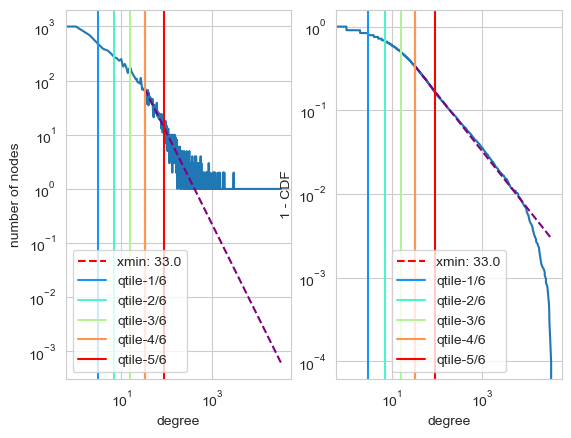

In [13]:
from benji_girgs.plotting import plot_degree_dist

plot_degree_dist(weighted_degrees.astype(np.int64), vlines=6, pl_fit=True)

In [14]:
np.sum(weighted_degrees[weighted_degrees < 6])
weighted_degrees.shape

7181.0

(10317,)

In [15]:
weight_thresh = 1
gthresh = nk.Graph(len(airports))
for u, v, weight in tqdm(g.iterEdgesWeights()):
    if weight >= weight_thresh:
        _ = gthresh.addEdge(u, v)

130704it [00:00, 2988607.95it/s]


In [16]:
nk.overview(gthresh)

Network Properties:
nodes, edges			10317, 130704
directed?			False
weighted?			False
isolated nodes			15
self-loops			0
density				0.002456
clustering coefficient		0.369664
min/max/avg degree		0, 864, 25.337598
degree assortativity		-0.013060
number of connected components	29
size of largest component	10274 (99.58 %)


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
powerlaw alpha: 2.103


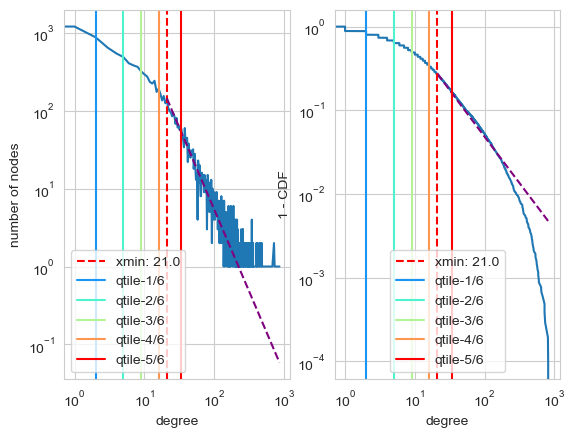

In [17]:
plot_degree_dist(gthresh, vlines=6, pl_fit=True)

In [18]:
adf_mini = adf.set_index('ident')
adf_mini = adf_mini.loc[airports]

In [19]:
# reversed s.t. latitude then longitude
adf_mini['coordinates'] = adf_mini.coordinates.apply(lambda x: tuple(reversed([float(y) for y in x.split(', ')])))

In [20]:
adf_mini['lat'] = adf_mini['coordinates'].apply(lambda x: x[0])
adf_mini['long'] = adf_mini['coordinates'].apply(lambda x: x[1])


In [23]:
gdf = gpd.GeoDataFrame(adf_mini, geometry=gpd.points_from_xy(adf_mini.long, adf_mini.lat))

In [24]:
n = len(airports)
dists = np.zeros((n, n))

for i in tqdm(range(1, n), total=n-1):
    x = gdf.geometry.distance(gdf.shift(periods=-i).geometry)[:-i]
    dists[np.arange(n-i), np.arange(n-i)+i] = x

100%|██████████| 10316/10316 [00:54<00:00, 189.92it/s]


In [93]:
gdf.loc['ZUCK'].geometry.distance(gdf.loc['00AK'].geometry)

260.10069933066666

In [99]:
gdf.loc['ZUCK'].geometry.xy

(array('d', [106.64199829101562]), array('d', [29.719200134277344]))

In [100]:
square = pd.DataFrame(
    np.zeros((n, n)),
    index=adf_mini.index, columns=adf_mini.index
)

In [103]:
end = adf_mini.loc['00AK', 'coordinates']

In [110]:
adf_mini.coordinates.apply(distance.distance, args=(end,), ellipsoid='WGS-84')

ident
00AK                   0.0 km
00AL     5349.974218859573 km
00AZ    4031.3139530844023 km
00CL     3090.913578766129 km
00FA     6160.861618098177 km
                ...          
Z19O     9538.732343575095 km
ZGGG     8055.052259312608 km
ZGSD     8181.755726940145 km
ZGSZ    8098.5830259205895 km
ZUCK     7805.232638548123 km
Name: coordinates, Length: 10317, dtype: object

In [107]:
distance.distance(adf_mini.loc['ZUCK', 'coordinates'], end, ellipsoid='WGS-84').km

7805.232638548123

In [119]:
temp = square = pd.DataFrame(
    np.zeros((10, 10)),
    index=adf_mini.index[:10], columns=adf_mini.index[:10]
)

In [120]:
np.random.random(10)

array([0.41090301, 0.82241178, 0.5403681 , 0.65431201, 0.25797233,
       0.40129581, 0.72830492, 0.5416213 , 0.16041609, 0.4444845 ])

In [122]:
foo = temp.apply(lambda col: np.random.random(10), axis=1)


In [126]:
n

10317

In [127]:
len(adf_mini)

10317

In [117]:
def get_distance(col):
    end_latlon = adf_mini.loc[col.name, 'coordinates']
    series = adf_mini.coordinates.apply(distance.distance, args=(end,), ellipsoid='WGS-84')
    return series.apply(lambda x: x.km)

distances = square.progress_apply(get_distance, axis=1).T

  0%|          | 0/10317 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [153]:
tau = 2.103
alpha = 1.2
d=2
const=1/2000
weights = generation.generateWeights(n, tau)
outer = np.outer(weights, weights)
p_uv = np.divide(outer, dists**d)
p_uv = const * np.power(p_uv, alpha)
p_uv = np.minimum(p_uv, 1)
unif_mat = np.random.uniform(size=p_uv.shape)
edges = np.triu((unif_mat < p_uv).astype(np.uint), 1)


/var/folders/60/0t2c_bns6n3c7kjhdk4d4wk80000gn/T/ipykernel_30822/3116270665.py:7: RuntimeWarning: divide by zero encountered in divide
  p_uv = np.divide(outer, dists**d)


In [154]:
g_girg = nk.nxadapter.nx2nk(nx.from_numpy_array(edges))

In [155]:
nk.overview(g_girg)

Network Properties:
nodes, edges			10317, 149496
directed?			False
weighted?			False
isolated nodes			414
self-loops			0
density				0.002809
clustering coefficient		0.542346
min/max/avg degree		0, 4925, 28.980518
degree assortativity		-0.122515
number of connected components	482
size of largest component	9681 (93.84 %)


In [137]:
nk.overview(gthresh)

Network Properties:
nodes, edges			10317, 130704
directed?			False
weighted?			False
isolated nodes			15
self-loops			0
density				0.002456
clustering coefficient		0.369664
min/max/avg degree		0, 864, 25.337598
degree assortativity		-0.013060
number of connected components	29
size of largest component	10274 (99.58 %)


In [33]:
degrees = np.array([gthresh.degree(i) for i in range(len(airports))]).astype(np.float64)
degrees[:10]

array([12., 14., 17., 13., 15., 17.,  5., 12., 27., 38.])

In [67]:
asdf = AirportGirgFitter(degrees, dists, gthresh)
asdf.alpha=1.01
asdf.const = 1.5e-4

percs_true_median: 0.41816672024000856, avg_degree_true: 25.337598138993894


In [68]:
for _ in range(10):
    asdf.step()

/var/folders/60/0t2c_bns6n3c7kjhdk4d4wk80000gn/T/ipykernel_56912/1634427249.py:52: RuntimeWarning: invalid value encountered in divide
  p_uv = np.divide(outer, self.dists**self.d)


percs_median: 0.470, girg_avg_degree: 27.052
scaly_thing: [0.3 0.3]
alpha: 0.857, const: 1.0500e-04
percs_median: 0.200, girg_avg_degree: 9.392
scaly_thing: [0.27145123 0.27145123]
alpha: 0.990, const: 1.4412e-04
percs_median: 0.426, girg_avg_degree: 24.091
scaly_thing: [0.24561923 0.24561923]
alpha: 0.870, const: 1.9105e-04
percs_median: 0.269, girg_avg_degree: 16.542
scaly_thing: [0.22224547 0.22224547]
alpha: 0.975, const: 2.4564e-04
percs_median: 0.450, girg_avg_degree: 32.891
scaly_thing: [0.20109601 0.20109601]
alpha: 0.880, const: 1.9624e-04
percs_median: 0.300, girg_avg_degree: 17.763
scaly_thing: [0.1819592 0.1819592]
alpha: 0.964, const: 2.3989e-04
percs_median: 0.430, girg_avg_degree: 30.849
scaly_thing: [0.16464349 0.16464349]
alpha: 0.888, const: 2.0040e-04
percs_median: 0.316, girg_avg_degree: 18.788
scaly_thing: [0.14897559 0.14897559]
alpha: 0.956, const: 2.3548e-04
percs_median: 0.424, girg_avg_degree: 29.281
scaly_thing: [0.13479869 0.13479869]
alpha: 0.894, const: 2.

In [69]:
for _ in range(10):
    asdf.step()

/var/folders/60/0t2c_bns6n3c7kjhdk4d4wk80000gn/T/ipykernel_56912/1634427249.py:52: RuntimeWarning: invalid value encountered in divide
  p_uv = np.divide(outer, self.dists**self.d)


percs_median: 0.413, girg_avg_degree: 28.109
scaly_thing: [0.11036383 0.11036383]
alpha: 1.005, const: 2.0643e-04
percs_median: 0.476, girg_avg_degree: 33.045
scaly_thing: [0.09986133 0.09986133]
alpha: 0.954, const: 1.8581e-04
percs_median: 0.412, girg_avg_degree: 24.592
scaly_thing: [0.09035826 0.09035826]
alpha: 0.999, const: 2.0427e-04
percs_median: 0.471, girg_avg_degree: 32.045
scaly_thing: [0.08175954 0.08175954]
alpha: 0.959, const: 1.8757e-04
percs_median: 0.417, girg_avg_degree: 25.169
scaly_thing: [0.07397909 0.07397909]
alpha: 0.995, const: 2.0255e-04
percs_median: 0.462, girg_avg_degree: 31.302
scaly_thing: [0.06693905 0.06693905]
alpha: 0.962, const: 1.8900e-04
percs_median: 0.417, girg_avg_degree: 25.700
scaly_thing: [0.06056896 0.06056896]
alpha: 0.992, const: 1.7755e-04
percs_median: 0.455, girg_avg_degree: 28.217
scaly_thing: [0.05480506 0.05480506]
alpha: 0.965, const: 1.6782e-04
percs_median: 0.419, girg_avg_degree: 23.945
scaly_thing: [0.04958967 0.04958967]
alpha:

In [ ]:
print('asdf', end='')
print('aaaaa')

In [ ]:
a = np.arange(10).reshape(2, 5)
a / a

/var/folders/60/0t2c_bns6n3c7kjhdk4d4wk80000gn/T/ipykernel_56912/1634427249.py:52: RuntimeWarning: invalid value encountered in divide
  p_uv = np.divide(outer, self.dists**self.d)


percs_median: 0.417, girg_avg_degree: 25.360
scaly_thing: [0.04060058 0.04060058]
alpha: 0.982, const: 1.7736e-04
percs_median: 0.452, girg_avg_degree: 26.868
scaly_thing: [0.03673693 0.03673693]
alpha: 0.964, const: 1.7085e-04
percs_median: 0.414, girg_avg_degree: 24.158
scaly_thing: [0.03324095 0.03324095]
alpha: 0.980, const: 1.7672e-04
percs_median: 0.438, girg_avg_degree: 26.664
scaly_thing: [0.03007765 0.03007765]
alpha: 0.966, const: 1.7141e-04
percs_median: 0.414, girg_avg_degree: 24.443
scaly_thing: [0.02721539 0.02721539]
alpha: 0.979, const: 1.7620e-04
percs_median: 0.436, girg_avg_degree: 26.467
scaly_thing: [0.0246255 0.0246255]
alpha: 0.967, const: 1.7186e-04
percs_median: 0.420, girg_avg_degree: 24.603
scaly_thing: [0.02228207 0.02228207]
alpha: 0.957, const: 1.7578e-04


In [64]:
asdf.alpha=1.00001
g_girg = asdf.gen_new_girg()

percs = utils.get_perc_lower_common_nhbs(g_girg, asdf.num_edges)
percs_median = np.median(percs)
girg_avg_degree = utils.avg_degree(g_girg)
print(f'percs_median: {percs_median:.3f}, girg_avg_degree: {girg_avg_degree:.3f}')

/var/folders/60/0t2c_bns6n3c7kjhdk4d4wk80000gn/T/ipykernel_56912/672834539.py:52: RuntimeWarning: invalid value encountered in divide
  p_uv = np.divide(outer, self.dists**self.d)


percs_median: 0.452, girg_avg_degree: 24.128


In [75]:
n**(1/2)

101.57263410978372

In [82]:
dists[0, :10]

array([ 0.        , 69.60296909, 47.11999646, 36.29203547, 76.20350889,
       72.51887491, 37.39390979, 64.6821617 , 65.66842699, 60.60255929])

In [83]:
dists[1, :10]

array([ 0.        ,  0.        , 25.40085524, 35.28929298,  7.70675133,
        2.91631359, 32.30020002,  7.64120327,  5.67173637,  9.02837381])

In [85]:
dists[0, -10:]

array([314.38980194, 304.49526193, 283.75622646, 314.29028666,
       316.3801238 , 189.12600536, 267.50467478, 267.77382308,
       268.11563488, 260.10069933])

In [86]:
airports[:4]
airports[-4:]

['00AK', '00AL', '00AZ', '00CL']

['ZGGG', 'ZGSD', 'ZGSZ', 'ZUCK']

In [87]:
adf_mini.loc['ZUCK']

type                                            large_airport
name                 Chongqing Jiangbei International Airport
elevation_ft                                           1365.0
continent                                                  AS
iso_country                                                CN
iso_region                                              CN-50
municipality                                        Chongqing
gps_code                                                 ZUCK
iata_code                                                 CKG
local_code                                                NaN
coordinates          (29.719200134277344, 106.64199829101562)
lat                                                   29.7192
long                                               106.641998
geometry        POINT (106.64199829101562 29.719200134277344)
Name: ZUCK, dtype: object

In [88]:
adf_mini.loc['00AK']

type                                 small_airport
name                                  Lowell Field
elevation_ft                                 450.0
continent                                      NaN
iso_country                                     US
iso_region                                   US-AK
municipality                          Anchor Point
gps_code                                      00AK
iata_code                                      NaN
local_code                                    00AK
coordinates          (59.94919968, -151.695999146)
lat                                        59.9492
long                                   -151.695999
geometry        POINT (-151.695999146 59.94919968)
Name: 00AK, dtype: object

In [92]:
distance.distance((59.9, -151.6), (29.7, 106.6)).km

7816.368015732929

In [90]:
from geopy import distance

In [ ]:
gdf_

In [66]:
def scale_param(param, scale, base, larger=True):
    if larger:
        return base + (param - base) * (1 - scale)**(-1)
    else:
        return base + (param - base) * (1 - scale)
    

class GirgFitter:
    def __init__(self):
        self.t = 0
        self.temp_scalers = [0.1]
        self.scalers = [0.3]

    def gen_new_girg(self):
        new_girg = None
        return new_girg

    def step(self):
        girg = self.gen_new_girg()
        # do some decisions
        ...
        self.t += 1
    
    def step_n(self, n):
        for i in range(n):
            self.step()


class AirportGirgFitter(GirgFitter):
    n = 10317
    d = 2
    tau = 2.103
    num_edges = 6000
    def __init__(self, weights, dists, g_true):
        self.t = 0
        self.temp_scalers = np.array([0.1, 0.1])
        self.scalers = np.array([0.3, 0.3])
        self.alpha = 1.2
        self.const = 1/2000

        self.weights = weights # n vector of weights
        self.dists = dists  # nxn matrix of distances
        self.g_true = g_true

        percs = utils.get_perc_lower_common_nhbs(g_true, self.num_edges)
        self.percs_true_median = np.median(percs)
        self.avg_degree_true = utils.avg_degree(g_true)
        print(f'percs_true_median: {self.percs_true_median}, avg_degree_true: {self.avg_degree_true}')

    def gen_new_girg(self):
        outer = np.outer(self.weights, self.weights)
        p_uv = np.divide(outer, self.dists**self.d)
        p_uv = self.const * np.power(p_uv, self.alpha)
        p_uv = np.minimum(p_uv, 1)
        unif_mat = np.random.uniform(size=p_uv.shape)
        edges = np.triu((unif_mat < p_uv).astype(np.uint), 1)
        g_girg = nk.nxadapter.nx2nk(nx.from_numpy_array(edges))
    
        return g_girg
    
    def step(self):
        g_girg = self.gen_new_girg()
        # do some decisions
        percs = utils.get_perc_lower_common_nhbs(g_girg, self.num_edges)
        percs_median = np.median(percs)
        girg_avg_degree = utils.avg_degree(g_girg)
        print(f'percs_median: {percs_median:.3f}, girg_avg_degree: {girg_avg_degree:.3f}')

        scaly_thing = self.scalers * np.exp(-self.temp_scalers * self.t)
        print(f'scaly_thing: {scaly_thing}')

        larger = percs_median < self.percs_true_median
        self.alpha = scale_param(self.alpha, scaly_thing[0], 0.5, larger)
        larger = self.avg_degree_true > girg_avg_degree
        self.const = scale_param(self.const, scaly_thing[1], 0, larger)

        print(f'alpha: {self.alpha:.3f}, const: {self.const:.4e}')
        self.t += 1

In [42]:
girg_avg_degree = 250.0
larger = asdf.avg_degree_true > girg_avg_degree
scale_param(asdf.const, 0.3, 0, larger)

0.0034013605442176874

In [56]:
np.seterr(divide='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [58]:
np.seterr(divide='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [45]:
(1-0.3)**(-1)

1.4285714285714286

In [65]:
adf_mini

,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,lat,long,geometry
ident,,,,,,,,,,,,,,
00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"(59.94919968, -151.695999146)",59.949200,-151.695999,POINT (-151.69600 59.94920)
00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"(34.86479949951172, -86.77030181884766)",34.864799,-86.770302,POINT (-86.77030 34.86480)
00AZ,small_airport,Cordes Airport,3810.0,NaN,US,US-AZ,Cordes,00AZ,NaN,00AZ,"(34.305599212646484, -112.16500091552734)",34.305599,-112.165001,POINT (-112.16500 34.30560)
00CL,small_airport,Williams Ag Airport,87.0,NaN,US,US-CA,Biggs,00CL,NaN,00CL,"(39.427188, -121.763427)",39.427188,-121.763427,POINT (-121.76343 39.42719)
00FA,small_airport,Grass Patch Airport,53.0,NaN,US,US-FL,Bushnell,00FA,NaN,00FA,"(28.64550018310547, -82.21900177001953)",28.645500,-82.219002,POINT (-82.21900 28.64550)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z19O,medium_airport,Wujah Al Hajar Air Base,840.0,AS,LB,LB-AS,Hamat,NaN,NaN,Z19O,"(34.281226, 35.680096)",34.281226,35.680096,POINT (35.68010 34.28123)
ZGGG,large_airport,Guangzhou Baiyun International Airport,50.0,AS,CN,CN-44,Guangzhou,ZGGG,CAN,NaN,"(23.39240074157715, 113.29900360107422)",23.392401,113.299004,POINT (113.29900 23.39240)
ZGSD,medium_airport,Zhuhai Jinwan Airport,23.0,AS,CN,CN-44,Zhuhai,ZGSD,ZUH,NaN,"(22.006399, 113.375999)",22.006399,113.375999,POINT (113.37600 22.00640)
